<a id='Q0'></a>
<center><a target="_blank" href="https://learning.constructor.org/"><img src="https://drive.google.com/uc?id=1wxkbM60NlBlkbGK1JqUypKL24RrTiiYk" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center>Constructor Learning, 2023</center>

# Exercise: Feed-forward NNs for Structured Data Classification


## Introduction

The idea of this exercise is to learn how to do structured data classification using neural networks, starting from a raw
CSV file. Our data includes both numerical and categorical features. 

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Key Objectives - Day 1


1. Your key task is to perform a binary classification problem to predict heart disease based on the given data by splitting it into train-valid-test datasets

2. You will build a variety of dense neural network models starting from simple 1-layer NNs to 2 and 3 layer dense NNs

3. You will also plot learning curves to visualize training performance over epochs

4. You will also evaluate the performance of the models on the test dataset

5. You will also build a model using class weights to tackle class imbalance



## Load Dependencies

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

In [2]:
tf.random.set_seed(3) # reproducibility

## Load the dataset

Let's download the data and load it into a Pandas dataframe:

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [ ]:
df.shape

(303, 14)

In [ ]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


Here's a preview of a few samples:

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

## Check the distribution of the target column

In [ ]:
df.target.value_counts()

0    220
1     83
Name: target, dtype: int64

## Task 1: Split Dataset into Train, Validation and Test Datasets

Use stratified sampling to ensure similar `target` class distribution in the dataset splits when using `train_test_split()`

Use a split of 60:20:20 for train-valid-test splits
For reproducibility set the `random_state` to `42`

In [4]:
X=df.drop(columns=['target'])
y=df['target']

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.2, stratify = y_train_full)

In [6]:
X_train_full.shape, X_train.shape, X_valid.shape

((242, 13), (193, 13), (49, 13))

## Task 2: Data Pre-processing

Recall the data pre-processing you had learnt during the ML week! Perform the following tasks to have clean and pre-processed datasets for your training, validation and test datasets.

Key Steps:

1. One-hot encode categorical data
2. Standard Scaling numerical data
3. Combine categorical and numeric data together into a single dataframe \ numpy array

Hints: Leverage code from [here](https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/04_MachineLearning/day3/pages/MLG_D3_LC2_Classification_Models_Tackling_Class_Imbalance.html#Separate-categorical-and-numeric-columns) [pre-processing parts only]

In [15]:
# Define feature / target columns

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])
numeric_transformer = Pipeline(steps=[
                                      ("scaler", StandardScaler())
                                      ])
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])


In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                                  'restecg', 'thalach', 'exang', 'oldpeak',
                                  'slope', 'ca']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['thal'])])

In [16]:
pc_X_train=preprocessor.fit_transform(X_train)
pc_X_valid=preprocessor.transform(X_valid)
pc_X_test=preprocessor.transform(X_test)

In [17]:
feature_names = preprocessor.get_feature_names_out()
pc_X_train=pd.DataFrame(pc_X_train, columns=feature_names) 
pc_X_valid= pd.DataFrame(pc_X_valid, columns=feature_names) 
pc_X_test = pd.DataFrame(pc_X_test, columns=feature_names) 

##CREATE Plot function to check the model 

In [18]:
import matplotlib.pyplot as plt


def plot_metrics(history):

  keys = history.history.keys()
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.capitalize()
    metric_name = [item for item in keys if metric in item and 'val_'+metric not in item][0]
    val_metric_name = [item for item in keys if 'val_'+metric in item][0]
    
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
    plt.plot(history.epoch, history.history[val_metric_name], color='r', 
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

## Task 3: Experimenting with NN layer activation functions
Run the following experiments separately to train multi-layer neural networks with different activation functions, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Experiment 1 - 3-layer NN with ELU activation



In [19]:
#Class_weight : unbalance in outcome var. 
class_weight = class_weight.compute_class_weight(class_weight = 'balanced', 
                                               classes = np.unique(y_train),
                                               y = y_train)
class_weight = dict(enumerate(class_weight))


In [24]:
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32, 
                                                          activation="elu",
                                                          input_shape=(input_shape,)), #input
                                    tf.keras.layers.Dense(32, 
                                                          activation="elu"), #Neuron 1
                                    tf.keras.layers.Dense(32, 
                                                          activation="elu"), #Neuron 2
                                    tf.keras.layers.Dense(32, 
                                                          activation="elu"), #Neuron 3
                                    tf.keras.layers.Dense(1, 
                                                          activation="sigmoid")] #output 
                                   )

# optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=adam_optimizer, 
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

history = model.fit(pc_X_train, y_train, 
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1, 
                    callbacks=[early_stopping], 
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 4s 85ms/step - loss: 0.6929 - accuracy: 0.5233 - precision_1: 0.2903 - recall_1: 0.5094 - val_loss: 0.5885 - val_accuracy: 0.8163 - val_precision_1: 0.6250 - val_recall_1: 0.7692
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.5523 - accuracy: 0.7358 - precision_1: 0.5111 - recall_1: 0.8679 - val_loss: 0.5076 - val_accuracy: 0.8367 - val_precision_1: 0.6471 - val_recall_1: 0.8462
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 0.4767 - accuracy: 0.7461 - precision_1: 0.5208 - recall_1: 0.9434 - val_loss: 0.4520 - val_accuracy: 0.8571 - val_precision_1: 0.6875 - val_recall_1: 0.8462
Epoch 4/500
7/7 [==============================] - 0s 15ms/step - loss: 0.4379 - accuracy: 0.7617 - precision_1: 0.5385 - recall_1: 0.9245 - val_loss: 0.4234 - val_accuracy: 0.8571 - val_precision_1: 0.6875 - val_recall_1: 0.8462
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 0.4170 -

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        44
           1       0.73      0.65      0.69        17

    accuracy                           0.84        61
   macro avg       0.80      0.78      0.79        61
weighted avg       0.83      0.84      0.83        61



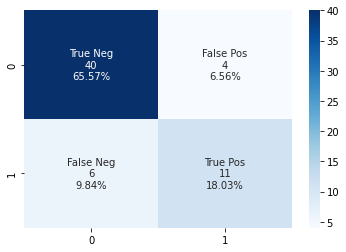

In [25]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

cr=classification_report(y_test,y_pred_classes)
print(cr)

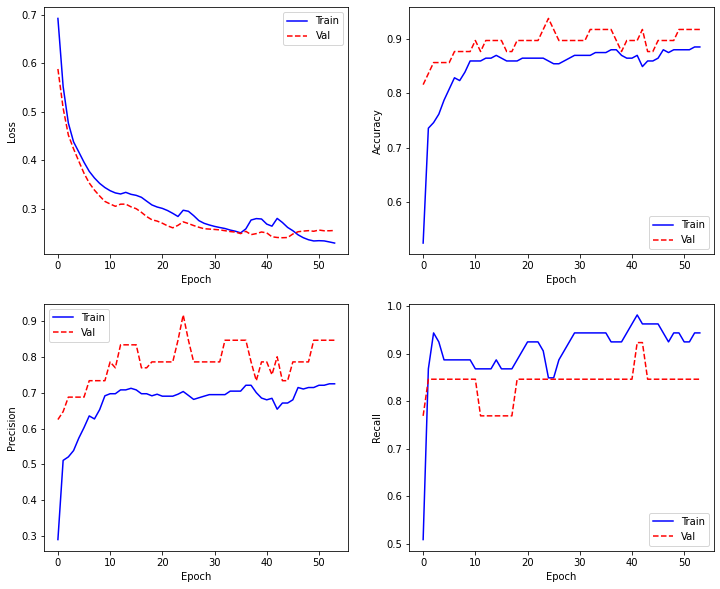

In [26]:
plot_metrics(history)

In [27]:
# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

MSE of test set: [0.3955153226852417, 0.8360655903816223, 0.7333333492279053, 0.6470588445663452]


Experiment 2 - 3-layer NN with LeakyReLU activation

In [28]:
# TODO: Add number of output neurons    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32, 
                                                          activation=tf.keras.layers.LeakyReLU(),
                                                          input_shape=(input_shape,)), #input
                                    tf.keras.layers.Dense(32, 
                                                          activation=tf.keras.layers.LeakyReLU()), #Neuron 1
                                    tf.keras.layers.Dense(32, 
                                                          activation=tf.keras.layers.LeakyReLU()), #Neuron 2
                                    tf.keras.layers.Dense(32, 
                                                          activation=tf.keras.layers.LeakyReLU()), #Neuron 3
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
                                    )

# optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=adam_optimizer,
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
              )
#Define early_stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

#Model fit
history = model.fit(pc_X_train, y_train,
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 2s 61ms/step - loss: 0.6947 - accuracy: 0.6839 - precision_2: 0.3667 - recall_2: 0.2075 - val_loss: 0.6311 - val_accuracy: 0.7959 - val_precision_2: 0.6364 - val_recall_2: 0.5385
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.6371 - accuracy: 0.7358 - precision_2: 0.5147 - recall_2: 0.6604 - val_loss: 0.6113 - val_accuracy: 0.7347 - val_precision_2: 0.5000 - val_recall_2: 0.6923
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.5926 - accuracy: 0.7565 - precision_2: 0.5349 - recall_2: 0.8679 - val_loss: 0.5723 - val_accuracy: 0.7959 - val_precision_2: 0.5882 - val_recall_2: 0.7692
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.5563 - accuracy: 0.7668 - precision_2: 0.5488 - recall_2: 0.8491 - val_loss: 0.5307 - val_accuracy: 0.8571 - val_precision_2: 0.7143 - val_recall_2: 0.7692
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 0.5249 - a

2/2 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.81      0.76      0.79        17

    accuracy                           0.89        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.88      0.89      0.88        61



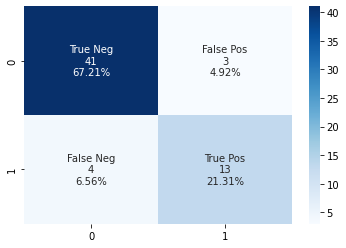

In [32]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)

##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

cr=classification_report(y_test,y_pred_classes)
print(cr)

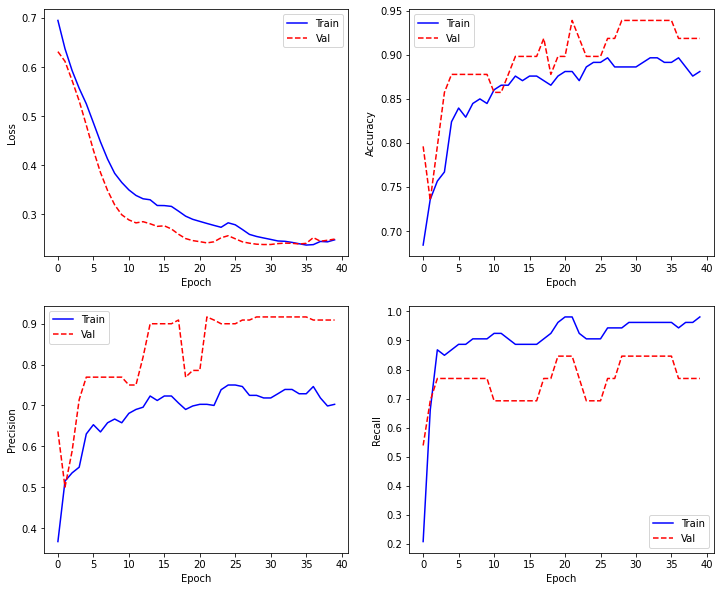

In [33]:
plot_metrics(history)

In [34]:
# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

MSE of test set: [0.33820250630378723, 0.8852459192276001, 0.8125, 0.7647058963775635]


##Task 4: Regularization in NNs
Run the following experiments separately to train multi-layer neural networks with different methods of regularization, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset. We will try the following methods for regularization:







BatchNormalization

In [35]:

# Model definition    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32,
                                                          activation="relu",
                                                          use_bias=False,
                                                          input_shape=(input_shape,)), #input
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False), #Neuron 1
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False), #Neuron 2
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False), #Neuron 3
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
                                   )

# Optmizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=adam_optimizer, 
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor='val_loss')

#Fitting the model into the data
history = model.fit(pc_X_train, y_train,
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 3s 67ms/step - loss: 0.6286 - accuracy: 0.6528 - precision_3: 0.4205 - recall_3: 0.6981 - val_loss: 0.6970 - val_accuracy: 0.4898 - val_precision_3: 0.3333 - val_recall_3: 0.9231
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.5594 - accuracy: 0.6995 - precision_3: 0.4706 - recall_3: 0.7547 - val_loss: 0.6674 - val_accuracy: 0.7347 - val_precision_3: 0.5000 - val_recall_3: 0.6923
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 0.4727 - accuracy: 0.7513 - precision_3: 0.5294 - recall_3: 0.8491 - val_loss: 0.6380 - val_accuracy: 0.7959 - val_precision_3: 0.6000 - val_recall_3: 0.6923
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.4628 - accuracy: 0.7824 - precision_3: 0.5679 - recall_3: 0.8679 - val_loss: 0.6135 - val_accuracy: 0.8367 - val_precision_3: 0.7273 - val_recall_3: 0.6154
Epoch 5/500
7/7 [==============================] - 0s 10ms/step - loss: 0.4019 -

2/2 [==============================] - 0s 5ms/step
[[39  5]
 [ 8  9]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        44
           1       0.64      0.53      0.58        17

    accuracy                           0.79        61
   macro avg       0.74      0.71      0.72        61
weighted avg       0.78      0.79      0.78        61

MSE of test set: [0.45342981815338135, 0.7868852615356445, 0.6428571343421936, 0.529411792755127]


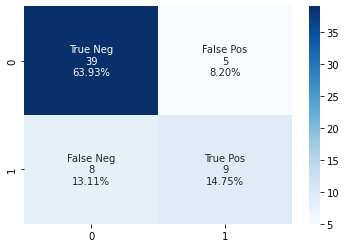

In [36]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

cr=classification_report(y_test,y_pred_classes)
print(cr)

# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

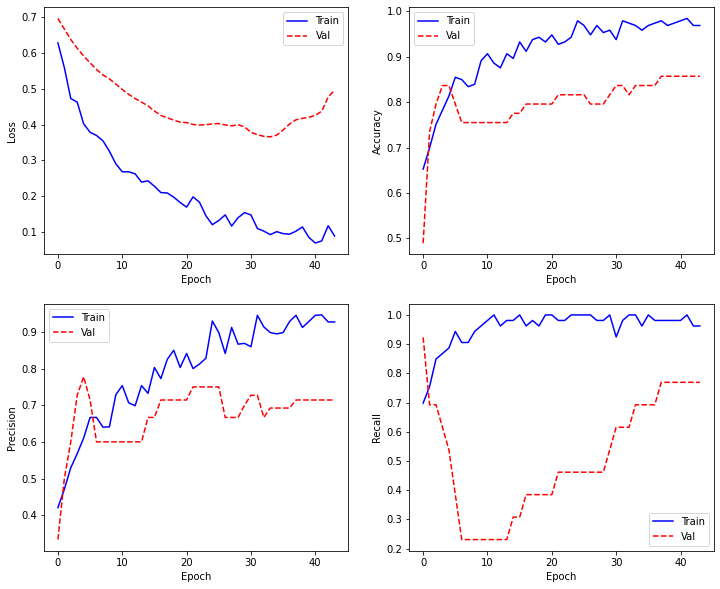

In [37]:
plot_metrics(history)

##Dropout

: kernel_initializer="lecun_normal"

In [40]:
# Model definition    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32,
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          input_shape=(input_shape,)), #input
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32,
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal"), #Neuron 1
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal"), #Neuron 2
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal"), #Neuron 3
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
                                   )

# optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=adam_optimizer, 
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor='val_loss')
#Fitting the model into the data
history = model.fit(pc_X_train, y_train,
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid),
                    verbose=1,callbacks=[early_stopping],
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 4s 67ms/step - loss: 0.7258 - accuracy: 0.5751 - precision_5: 0.3371 - recall_5: 0.5660 - val_loss: 0.6860 - val_accuracy: 0.5102 - val_precision_5: 0.3333 - val_recall_5: 0.8462
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.5689 - accuracy: 0.6684 - precision_5: 0.4396 - recall_5: 0.7547 - val_loss: 0.6701 - val_accuracy: 0.5918 - val_precision_5: 0.3793 - val_recall_5: 0.8462
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.4528 - accuracy: 0.7772 - precision_5: 0.5625 - recall_5: 0.8491 - val_loss: 0.6537 - val_accuracy: 0.6735 - val_precision_5: 0.4400 - val_recall_5: 0.8462
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 0.4373 - accuracy: 0.7617 - precision_5: 0.5402 - recall_5: 0.8868 - val_loss: 0.6376 - val_accuracy: 0.7143 - val_precision_5: 0.4783 - val_recall_5: 0.8462
Epoch 5/500
7/7 [==============================] - 0s 10ms/step - loss: 0.4130 -

2/2 [==============================] - 0s 12ms/step
[[41  3]
 [11  6]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        44
           1       0.67      0.35      0.46        17

    accuracy                           0.77        61
   macro avg       0.73      0.64      0.66        61
weighted avg       0.75      0.77      0.74        61

MSE of test set: [0.4966757893562317, 0.7704917788505554, 0.6666666865348816, 0.3529411852359772]


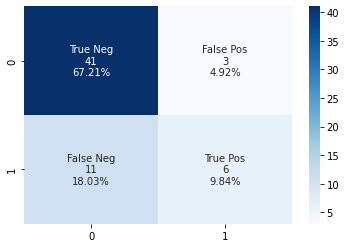

In [41]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')


cr=classification_report(y_test,y_pred_classes)
print(cr)

# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

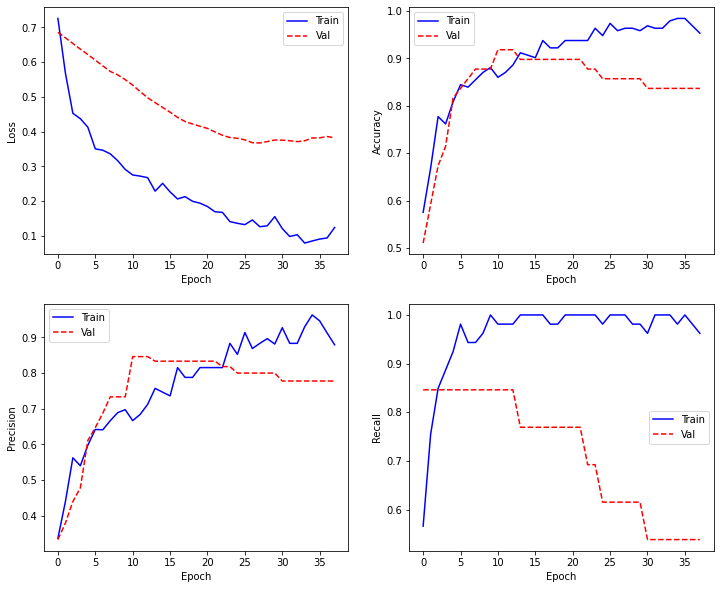

In [42]:
plot_metrics(history)

##Layer regularizer with L2 kernel

kernel_regularizer=keras.regularizers.l2(0.001)

In [43]:
# Model definition    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32,
                                                          activation="relu",
                                                          use_bias=False,
                                                          input_shape=(input_shape,)), #input
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32,
                                                          activation="relu",
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 1
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 2
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 3
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
                                   )

# optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=adam_optimizer, 
              metrics=["accuracy",
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

#Fitting the model into the data
history = model.fit(pc_X_train, y_train, 
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1, 
                    callbacks=[early_stopping], 
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 4s 69ms/step - loss: 0.8327 - accuracy: 0.5648 - precision_6: 0.3434 - recall_6: 0.6415 - val_loss: 0.7560 - val_accuracy: 0.6939 - val_precision_6: 0.2500 - val_recall_6: 0.0769
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 0.6572 - accuracy: 0.6580 - precision_6: 0.4356 - recall_6: 0.8302 - val_loss: 0.7557 - val_accuracy: 0.6735 - val_precision_6: 0.3636 - val_recall_6: 0.3077
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 0.5882 - accuracy: 0.7098 - precision_6: 0.4851 - recall_6: 0.9245 - val_loss: 0.7506 - val_accuracy: 0.6939 - val_precision_6: 0.4286 - val_recall_6: 0.4615
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 0.5564 - accuracy: 0.7409 - precision_6: 0.5161 - recall_6: 0.9057 - val_loss: 0.7427 - val_accuracy: 0.7551 - val_precision_6: 0.5333 - val_recall_6: 0.6154
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 0.5190 -

2/2 [==============================] - 0s 7ms/step
[[40  4]
 [10  7]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        44
           1       0.64      0.41      0.50        17

    accuracy                           0.77        61
   macro avg       0.72      0.66      0.68        61
weighted avg       0.75      0.77      0.75        61

MSE of test set: [0.7739052176475525, 0.7704917788505554, 0.6363636255264282, 0.4117647111415863]


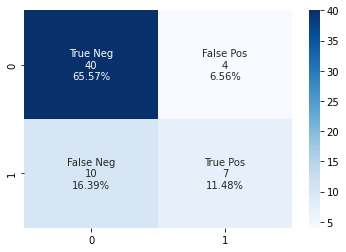

In [44]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)
##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

cr=classification_report(y_test,y_pred_classes)
print(cr)

# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

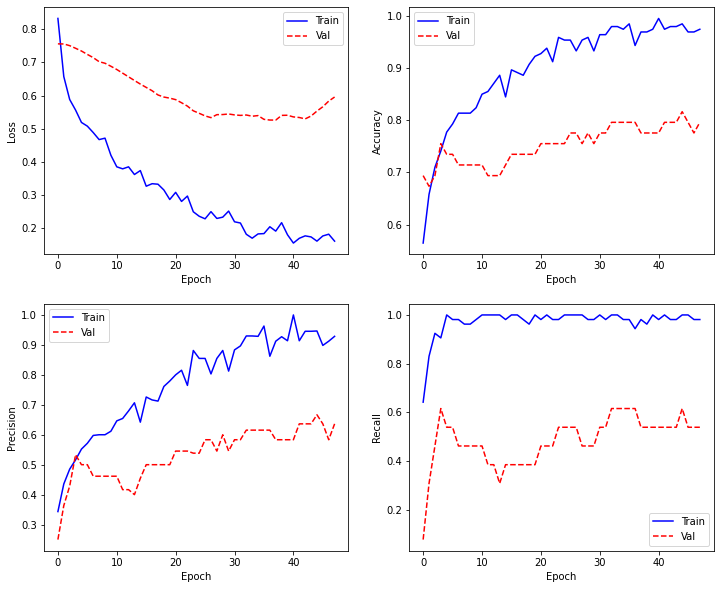

In [45]:
plot_metrics(history)

##Learning Rate Scheduling in NNs
Run the following experiments separately to train multi-layer neural networks with different methods of learning rate schedulers, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset. We will try the following methods for LR scheduling:



Exponential Decay

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=1e-4)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)


In [47]:
# Model definition    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32,
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          input_shape=(input_shape,)), #input
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 1
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 2
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 3
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
     )

# compile the model using optimizer
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                          decay_steps=10000,
                                                          decay_rate=1e-4)

lr_adam_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)




# model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=lr_adam_optimizer,
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()]
              )
#Define Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor='val_loss')

#Fitting the model into the data
n_epochs = 500
history = model.fit(pc_X_train, y_train, 
                    epochs=n_epochs, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1,
                    callbacks=[early_stopping], 
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 4s 101ms/step - loss: 0.7659 - accuracy: 0.5648 - precision_7: 0.3402 - recall_7: 0.6226 - val_loss: 0.7777 - val_accuracy: 0.5918 - val_precision_7: 0.2941 - val_recall_7: 0.3846
Epoch 2/500
7/7 [==============================] - 0s 17ms/step - loss: 0.6716 - accuracy: 0.6373 - precision_7: 0.4141 - recall_7: 0.7736 - val_loss: 0.7760 - val_accuracy: 0.5510 - val_precision_7: 0.3043 - val_recall_7: 0.5385
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.5617 - accuracy: 0.7150 - precision_7: 0.4898 - recall_7: 0.9057 - val_loss: 0.7700 - val_accuracy: 0.5510 - val_precision_7: 0.3043 - val_recall_7: 0.5385
Epoch 4/500
7/7 [==============================] - 0s 16ms/step - loss: 0.5412 - accuracy: 0.7098 - precision_7: 0.4845 - recall_7: 0.8868 - val_loss: 0.7598 - val_accuracy: 0.5714 - val_precision_7: 0.3182 - val_recall_7: 0.5385
Epoch 5/500
7/7 [==============================] - 0s 15ms/step - loss: 0.4845 

2/2 [==============================] - 0s 8ms/step
[[41  3]
 [ 8  9]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.75      0.53      0.62        17

    accuracy                           0.82        61
   macro avg       0.79      0.73      0.75        61
weighted avg       0.81      0.82      0.81        61

MSE of test set: [0.7324464917182922, 0.8196721076965332, 0.75, 0.529411792755127]


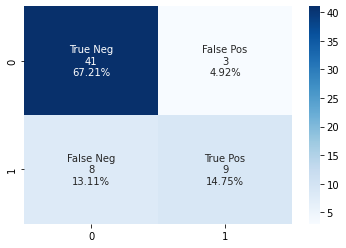

In [48]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

cr=classification_report(y_test,y_pred_classes)
print(cr)

# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

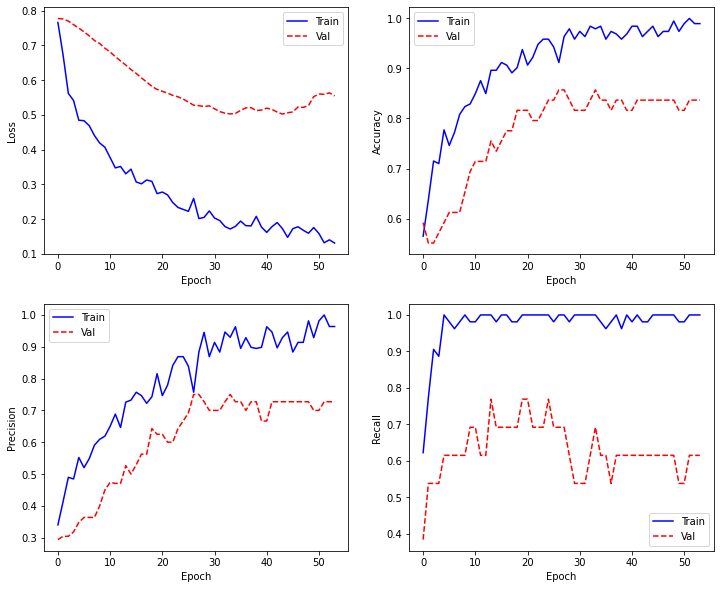

In [49]:
plot_metrics(history)

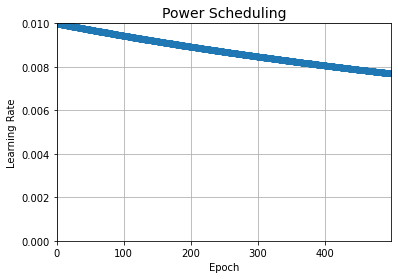

In [50]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs-1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

# Cosine Decay

tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, alpha=0.0, name=None
)

In [53]:
# Model definition    
input_shape=pc_X_train.shape[1]


model = tf.keras.models.Sequential([tf.keras.layers.Dense(32,
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001),
                                                          input_shape=(input_shape,)), #input
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 1
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu", 
                                                          use_bias=False, 
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 2
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, 
                                                          activation="relu",
                                                          use_bias=False,
                                                          kernel_initializer="lecun_normal",
                                                          kernel_regularizer=keras.regularizers.l2(0.001)), #Neuron 3
                                    keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(1, activation="sigmoid")] #output 
                                   )

# optimizer
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001,
                                                     alpha=0.05,
                                                     decay_steps=10000)
lr_adam_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)


# Model compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=lr_adam_optimizer,
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()],)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor='val_loss')

#Fitting the model into the data
n_epochs = 500
history = model.fit(pc_X_train, y_train, 
                    epochs=n_epochs, 
                    batch_size=32, 
                    validation_data=(pc_X_valid, y_valid), 
                    verbose=1, 
                    callbacks=[early_stopping],
                    class_weight=class_weight)

Epoch 1/500
7/7 [==============================] - 3s 69ms/step - loss: 0.8421 - accuracy: 0.5855 - precision_8: 0.3483 - recall_8: 0.5849 - val_loss: 0.7559 - val_accuracy: 0.7347 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.6772 - accuracy: 0.6632 - precision_8: 0.4412 - recall_8: 0.8491 - val_loss: 0.7476 - val_accuracy: 0.7551 - val_precision_8: 0.5556 - val_recall_8: 0.3846
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 0.5762 - accuracy: 0.7098 - precision_8: 0.4848 - recall_8: 0.9057 - val_loss: 0.7360 - val_accuracy: 0.7143 - val_precision_8: 0.4545 - val_recall_8: 0.3846
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.5149 - accuracy: 0.7927 - precision_8: 0.5714 - recall_8: 0.9811 - val_loss: 0.7252 - val_accuracy: 0.7347 - val_precision_8: 0.5000 - val_recall_8: 0.4615
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 

2/2 [==============================] - 0s 5ms/step
[[36  8]
 [10  7]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        44
           1       0.47      0.41      0.44        17

    accuracy                           0.70        61
   macro avg       0.62      0.61      0.62        61
weighted avg       0.69      0.70      0.70        61

MSE of test set: [0.752345860004425, 0.7049180269241333, 0.46666666865348816, 0.4117647111415863]


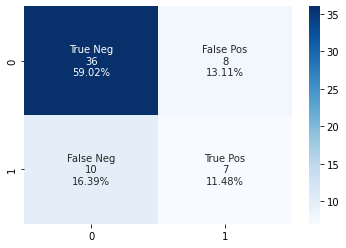

In [54]:
y_pred=model.predict(pc_X_test)
y_pred_classes = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

##Graphs for confusion matrix
names = ['True Neg','False Pos','False Neg','True Pos']
values = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,values,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

# Classification report
cr=classification_report(y_test, y_pred_classes)
print(cr)

# Validation on the test data set
eval_test = model.evaluate(pc_X_test, y_test, verbose=0)
print("MSE of test set: {}".format(eval_test))

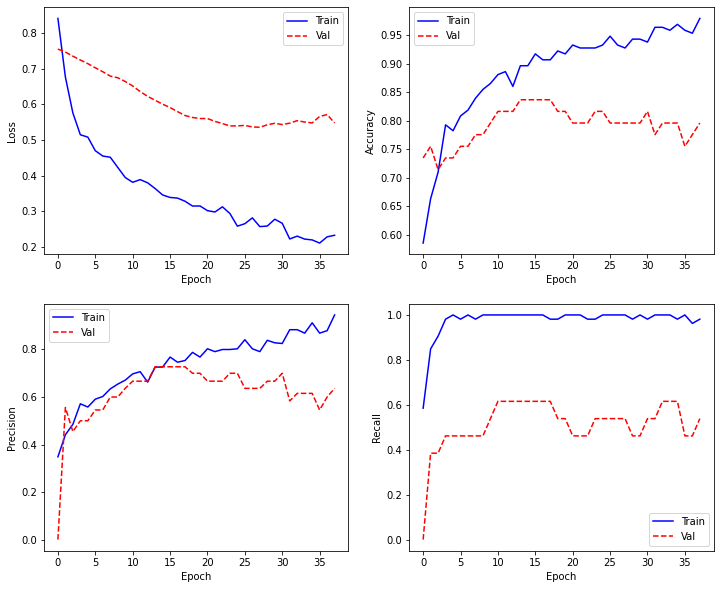

In [55]:
plot_metrics(history)

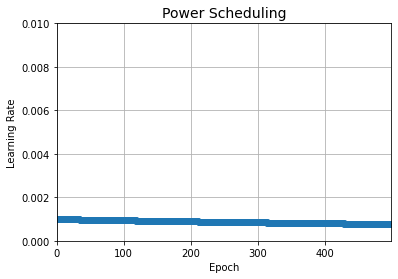

In [57]:
learning_rate = 0.001
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs-1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

##Hyperparameter Turning with Keras Tuner

In [59]:
# !pip install keras-tuner

In [60]:
import tensorflow as tf
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import kerastuner as kt

<ipython-input-60-3eccd682d52c>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:

# For the hyper-parameter tuning with Keras Tuner, 
# if you also want to check how many hidden layers work best, you can add your one hidden layer inside a loop inside the model_builder function as follows:

# max_layers = 6
# for i in range(hp.Int('layers', 2, max_layers)):
#       model.add(-->Your hidden layer here<--)

# model = tf.keras.Sequential()
# hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
# max_layers = 6
# for i in range(hp.Int('layers', 2, max_layers)):
#       model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', input_shape=(input_shape,)))
# ## etcetera


#????????????????????????????

In [61]:
input_shape=pc_X_train.shape[1]

def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32) # number of neurons per layers 

  #1st layer
  model.add(keras.layers.Dense(units = hp_units, 
                                activation = 'relu',
                                use_bias=False,
                                input_shape=(input_shape,)))
  model.add(keras.layers.BatchNormalization())

  # 2nd Dense layer

  model.add(keras.layers.Dense(units = hp_units, 
                                activation = 'relu',
                                use_bias=False))
  model.add(keras.layers.BatchNormalization())

  # 3rd Dense layer

  model.add(keras.layers.Dense(units = hp_units, 
                                activation = 'relu',
                                use_bias=False))
  model.add(keras.layers.BatchNormalization())

  #Output layer
  model.add(keras.layers.Dense(1, 
                                activation = 'sigmoid'))


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
              loss = keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy',
                          tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()])
  return model

In [62]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt') 

In [63]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [64]:
# y_train

In [65]:
tuner.search(x=pc_X_train, y=y_train, epochs=5, batch_size=64, validation_data=(pc_X_valid, y_valid), callbacks=[ClearTrainingOutput()]) 
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 00m 04s]
val_loss: 0.32100242376327515

Best val_loss So Far: 0.31868264079093933
Total elapsed time: 00h 02m 06s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



In [68]:
!pip install save

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for save: filename=save-0.1-py3-none-any.whl size=2821 sha256=4dd684f1761ae384c59ca55d261571b295edd67e5ef9636e28832cff4d9bd6e0
  Stored in directory: /root/.cache/pip/wheels/13/5d/54/65bdc05fdada64830e0cdff102bd23616526b8a9d5d5949009
Successfully built save


In [69]:
# Access the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=3)

# Access the entire list of trials
all_trials = tuner.oracle.trials

# Save the results to a file
import save
tuner.results_summary().save('tuner_results.txt') # ??????????????????

Results summary
Results in my_dir/intro_to_kt
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.31868264079093933
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.32100242376327515
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3266807198524475
Trial summary
Hyperparameters:
units: 160
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3471764028072357
Trial summary
Hyperparameters:
units: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.3484424650669098
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
tuner/epochs: 10
tuner/init

AttributeError: ignored

##TENSORBOARD